In [1]:
#!sudo pip3 install pyro-ppl -q
import pyro.distributions as dist
from pyro import plate
from pyro.distributions import Categorical
import pyro
import torch.nn as nn
import torch
import torch.distributions.constraints as constraints
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from spotlight.evaluation import sequence_mrr_score
import matplotlib.pyplot as plt
import numpy as np
def get_device(device = None):
    if device is not None:
        return torch.device(device)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device
device = get_device("cuda")

In [2]:
dataset = "rsc"
if dataset == "rsc":
    ##RCS DATA##
    from preproc import preprocess_rsc15
    dat, dat_seq , ind2val = preprocess_rsc15(density_value = None, limit_train = 300000, limit_test = None)
        
elif dataset == "generated":
    ## GENERATED DATA ##
    from preproc import preprocess_generated
    dat, dat_seq, ind2val = preprocess_generated()

# GENERATE A SMALLER TRAINING SET FOR METRIC TESTING
dat_seq = {name : torch.tensor(dat_seq[name].sequences).long().to(device) for name in ['train','test']}
dat_seq['train_small'] = dat_seq['train'][torch.randint(len(dat_seq['train']), (10000,))]

START load data
Loaded train set
	Events: 299999
	Sessions: 72172
	Items: 14654
	Span: 2014-04-01 / 2014-04-08

Loaded test set
	Events: 17294
	Sessions: 5083
	Items: 3423
	Span: 2014-09-29 / 2014-09-30

END load data  0.40897899999999865 c /  0.4071969985961914 s


In [3]:
class LSTMrec(nn.Module):
    def __init__(self, num_items, emb_dim, device):
        super(LSTMrec, self).__init__()
        self.num_items = num_items
        self.emb_dim = emb_dim
        
        ### CUDA
        self.device = device
        
        # ITEM EMB
        #self.V = pyro.param("Vpar", torch.rand(self.num_items, self.emb_dim).to(self.device)-0.5)
        self.V = nn.Embedding(embedding_dim= self.emb_dim,
                                           num_embeddings = self.num_items)
        #self.V = pyro.param("V", V.weight)
        
        ### LSTM
        self.linear = nn.Linear(1,1) #nn.ModuleList(nn.Parameter(torch.zeros((1,))))
        self.lstm = nn.LSTM(batch_first=True,
                                input_size=self.emb_dim,
                                hidden_size=self.emb_dim)
        
        # Need to permute before and after LSTM because LSTM's batch_first is not supported...
        self.permute_for_lstm = lambda x: x.permute(1,0,2)
        self.permute_back_lstm = lambda x: x.permute(1,0,2)
        
        if device.type == "cuda":
            self.cuda()    
    def forward(self, seq):
        """
        seq: a torch array with dimension (batch_size, sequence length).
        Needs to be long() and on right device. 
        
        Outputs log probabilities of all items. (todo: Let user specify which items to calc)
        """
        x_vecs = self.V(seq)
        z, _ = self.lstm(x_vecs)
        
        
        lprob = self.linear.bias + z.matmul(self.V.weight.t())
        return lprob
    
    def model(self, seq):
        bias = dist.Normal(0,1)
        mu0 = torch.zeros(self.emb_dim).to(self.device)
        var0 = torch.diag(torch.ones(self.emb_dim).to(self.device)*3)

        muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))

        with plate("item_loop", self.num_items):
            V = pyro.sample(f"V", dist.MultivariateNormal(muV, var0))

        # LIFT MODULE:
        prior = {'linear.bias' : bias,
                'V.weight' : Deterministic_distr(V)}
        lifted_module = pyro.random_module("net", self, prior= prior)
        

        lifted_reg_model = lifted_module()
        lifted_reg_model.lstm.flatten_parameters()

        with pyro.plate("data", len(seq), subsample_size=50) as ind:
            batch_seq = seq[ind,]
            batch_mask = (batch_seq!=0).float()

            lprobs = lifted_reg_model(batch_seq)
            data = pyro.sample("obs_x", 
                               dist.Categorical(logits=lprobs).mask(batch_mask).to_event(2), 
                               obs = batch_seq)
        return lifted_reg_model
    
    def guide(self, x):
                           
        bias_loc = pyro.param("bias_loc", torch.tensor(0.0).to(device))
        bias_scale = pyro.param("bias_scale", torch.tensor(2.0).to(device), constraint = constraints.positive)
        bias = dist.Normal(loc = bias_loc, scale = bias_scale)

        
        # GLOBAL V:
        muV_mean = pyro.param("muV_mean", torch.rand(self.emb_dim).to(self.device))
        global_triV = pyro.param("triangVpar", 
              torch.diag(0.5*torch.ones(self.emb_dim)).to(self.device), 
              constraint = constraints.lower_cholesky)
        muV = pyro.sample("muV", dist.MultivariateNormal(muV_mean, scale_tril=global_triV))
        
        ### ITEMS RVs ###
        # Each item has a factor it multiplies L with on diagonal. Inspiration: covar = L D L^t = (L D^0.5) (L D^0.5)ˆt
        # item_var is the D**2
        item_var = pyro.param("item_var_factor", (torch.rand(self.num_items)+0.5).to(device),
                              constraint = constraints.positive)
        D_V = torch.diag(torch.ones(self.emb_dim).to(device)).unsqueeze(0).repeat(len(item_var),1,1)*item_var.unsqueeze(1).unsqueeze(1)
        triV = global_triV.matmul(D_V)

        V = pyro.param("Vpar", torch.rand(self.num_items, self.emb_dim).to(self.device)-0.5)

        ## item latent vectors
        with plate("item_loop", self.num_items) as i:
            V = pyro.sample(f"V", dist.MultivariateNormal(V[i,], scale_tril=triV[i,]))
            
        posterior = {'linear.bias' : bias,
                'V.weight' : Deterministic_distr(V)}
        
        lifted_module = pyro.random_module("net", self, prior = posterior)
        
        lifted_reg_model = lifted_module()
        lifted_reg_model.lstm.flatten_parameters()
        return lifted_reg_model

    
class Deterministic_distr(pyro.distributions.Distribution):
    def __init__(self, V):
        self.V = V
    def sample(self):
        return self.V
    def log_prob(self,x):
        return torch.zeros(x.size()[0])
    

In [121]:
pyro.param("item_var_factor").min()

tensor(0.0068, device='cuda:0', grad_fn=<MinBackward1>)

In [119]:
pyro.param("triangVpar").matmul(pyro.param("triangVpar").t())*pyro.param("item_var_factor").max()**2

tensor([[ 1.2738,  0.8333, -0.4343,  0.2298],
        [ 0.8333,  1.3912, -1.0175,  0.4829],
        [-0.4343, -1.0175,  4.9211, -1.1583],
        [ 0.2298,  0.4829, -1.1583,  1.0699]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [4]:
def compute_hitrate(seq, num_recs = 20, tau = 6):
    posterior_predictive = seqrec.guide(seq)
    feature_seq = seq[:,:tau]
    test_seq = seq[:,tau:]
    
    lprob = posterior_predictive(feature_seq)
    topK = lprob.argsort(dim=2, descending=True)[:,-1,:num_recs]

    hitrate = torch.tensor(0.0)
    totrate = torch.tensor(0.0)
    for i in range(len(seq)):
        hitmatrix = topK[i].unsqueeze(1) == test_seq[i].unsqueeze(0)
        hitrate += hitmatrix.sum()
        totrate += (test_seq[i] != 0).sum()
        
    return (hitrate/totrate).item()

In [5]:
def torch_unique_ordered(seq, K, device):
    return torch.tensor(numpy_unique_ordered(seq.cpu().numpy())[:K]).to(device)

def numpy_unique_ordered(seq):
    """Remove duplicate from a list while keeping order with Numpy.unique
    Required:
        seq: A list containing all items
    Returns:
        A list with only unique values. Only the first occurence is kept.
    """
    array_unique = np.unique(seq, return_index=True)
    dstack = np.dstack(array_unique)
    dstack.dtype = np.dtype([('v', dstack.dtype), ('i', dstack.dtype)])
    dstack.sort(order='i', axis=1)
    return dstack.flatten()['v']#.tolist()

In [6]:
def compute_bayesian_hitrate(seq, num_recs = 20, tau = 6, num_samples = None):
    feature_seq = seq[:,:tau]
    test_seq = seq[:,tau:]
    
    if num_samples is None:
        num_samples = num_recs
    # SAMPLE ALL POSTERIORS
    topK_samples = []
    for i in range(num_samples):
        posterior_predictive = seqrec.guide(feature_seq)
        pp = posterior_predictive(feature_seq)[:,-1]
        topK = pp.argsort(dim=1, descending=True)[:,:num_recs] # swap with torch.topk
        topK_samples.append(topK.unsqueeze(2))

    all_recs = torch.cat(topK_samples,2) # dim : (batch, topK, samples)
    # sum up across users:
    hitrate = torch.tensor(0.0)
    totrate = torch.tensor(0.0)
    misrate = torch.tensor(0.0)
    for i in range(len(seq)):
        onerec = all_recs[i,]
        recs = torch_unique_ordered(onerec.flatten(), K = num_recs, device = device)
        hitmatrix = recs.unsqueeze(1) == test_seq[i].unsqueeze(0)
        misrate += num_recs - len(recs)
        hitrate += hitmatrix.sum()
        totrate += (test_seq[i] != 0).sum() # all that are not the padding index count
    if misrate > 0:
        print("Found positive misrate!")
        print(hitrate, totrate, misrate)
    return (hitrate/totrate).item() #, all_recs, test_seq

In [7]:
print("Initializing model")
pyro.clear_param_store()
seqrec = LSTMrec(len(ind2val['itemId'])+1, emb_dim = 4, device = device)
seqrec

Initializing model


LSTMrec(
  (V): Embedding(14655, 4)
  (linear): Linear(in_features=1, out_features=1, bias=True)
  (lstm): LSTM(4, 4, batch_first=True)
)

In [8]:
%%time
n_steps = 1001
num_recs = 10
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(seqrec.model, seqrec.guide, optimizer, loss=Trace_ELBO())

imgs = []
# do gradient steps
for step in range(n_steps):
    loss = svi.step(dat_seq['train'])

    if step%50== 0:
        # COMPUTE ALL TYPES OF HITRATES...:
        hitrate_train = compute_bayesian_hitrate(dat_seq['train_small'], num_recs = num_recs, num_samples=1)
        hitrate_test = compute_bayesian_hitrate(dat_seq['test'], num_recs = num_recs, num_samples=1)
        bayeshit_train = compute_bayesian_hitrate(dat_seq['train_small'], num_recs = num_recs, num_samples=3)
        bayeshit_test = compute_bayesian_hitrate(dat_seq['test'], num_recs = num_recs, num_samples=3)
        print(f"step: {step} \t loss: {loss:.0f} \t TRAIN hitrate: freq/bayes: {hitrate_train:.3f} / {bayeshit_train:.3f}  \t TEST hitrate: freq/bayes: {hitrate_test:.3f} / {bayeshit_test:.3f}")


step: 0 	 loss: 138847853 	 TRAIN hitrate: freq/bayes: 0.010 / 0.002  	 TEST hitrate: freq/bayes: 0.001 / 0.000
step: 50 	 loss: 112981715 	 TRAIN hitrate: freq/bayes: 0.042 / 0.042  	 TEST hitrate: freq/bayes: 0.004 / 0.003
step: 100 	 loss: 77573118 	 TRAIN hitrate: freq/bayes: 0.055 / 0.058  	 TEST hitrate: freq/bayes: 0.005 / 0.006
step: 150 	 loss: 93628561 	 TRAIN hitrate: freq/bayes: 0.062 / 0.060  	 TEST hitrate: freq/bayes: 0.007 / 0.006
step: 250 	 loss: 88873320 	 TRAIN hitrate: freq/bayes: 0.057 / 0.060  	 TEST hitrate: freq/bayes: 0.005 / 0.005
step: 300 	 loss: 89880137 	 TRAIN hitrate: freq/bayes: 0.064 / 0.064  	 TEST hitrate: freq/bayes: 0.009 / 0.009
step: 350 	 loss: 64972137 	 TRAIN hitrate: freq/bayes: 0.061 / 0.062  	 TEST hitrate: freq/bayes: 0.008 / 0.007
step: 400 	 loss: 83574982 	 TRAIN hitrate: freq/bayes: 0.066 / 0.063  	 TEST hitrate: freq/bayes: 0.009 / 0.010
step: 450 	 loss: 90530953 	 TRAIN hitrate: freq/bayes: 0.064 / 0.063  	 TEST hitrate: freq/bayes

## Plot distribution of items

## Variability in item factor over number of events on the item

### All items plotted

Item activity/uncertainty correlation: -0.10


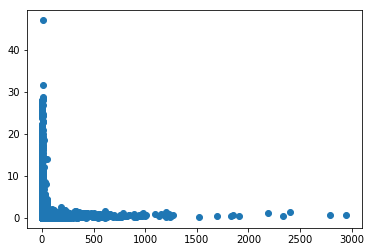

In [143]:
def get_counts(sequence, num):
    ids, id_count = np.unique(sequence, return_counts=True)
    counts = np.zeros(num)
    counts[ids] = id_count
    return counts

#user_counts = get_counts(train.user_ids, train.num_users)#[1:]
#user_factors = pyro.param("user_var_factor").detach().cpu().numpy()#[1:]
#print(f"User activity/uncertainty correlation: {np.corrcoef(user_factors, user_counts)[1,0]:.2f}")
#_ = plt.plot(user_counts, user_factors, "o")
#plt.show()

item_counts = get_counts(dat_seq['train'].cpu().numpy(), 1+len(ind2val['itemId']))[1:]
item_factors = pyro.param("item_var_factor").detach().cpu().numpy()[1:]
print(f"Item activity/uncertainty correlation: {np.corrcoef(item_factors, item_counts)[1,0]:.2f}")
_ = plt.plot(item_counts, item_factors, "o")
plt.show()

### Grouped by item-count

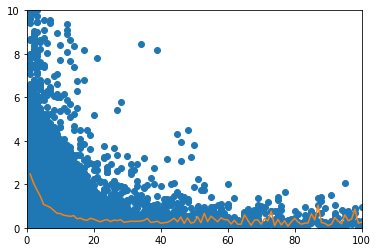

In [154]:
_ = plt.plot(item_counts, item_factors, "o")

import pandas as pd
item_variability = pd.DataFrame({'item_counts' : item_counts,
             'item_factors' : item_factors})
per_item_count = item_variability.groupby('item_counts')['item_factors'].median().reset_index()
_ = plt.plot(per_item_count.item_counts, per_item_count.item_factors)
axes = plt.gca()
_ = axes.set_xlim([0,100])
_ = axes.set_ylim([0,10])

Random items:


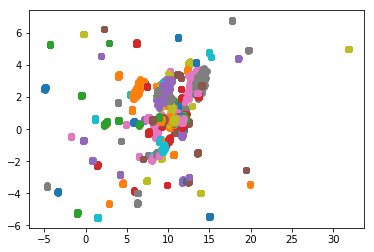

Most and least certain item:


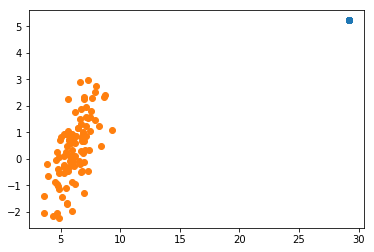

In [42]:
def plot_distr_of_items(items):
    sample_weights = []

    for _ in range(100):
        posterior_predictive = seqrec.guide(dat_seq['train_small'])
        sample_weights.append(posterior_predictive.V.weight[items,].unsqueeze(0))
    samples = torch.cat(sample_weights, dim = 0).cpu().detach().numpy()
    for u in range(len(items)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")

print("Random items:")
items = torch.randint(low=1, high=len(ind2val['itemId']), size = (200,))
plot_distr_of_items(items)
plt.show()
items = np.array([pyro.param("item_var_factor").argmin().item(), pyro.param("item_var_factor").argmax().item()])
print("Most and least certain item:")
plot_distr_of_items(items)